## Drugi zadatak
<hr>

Automatsko numerisanje jednačina

In [68]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Importi

In [69]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import as_strided
import time
from IPython.display import clear_output

from IPython.display import display, HTML

HTML centriranje plotova

In [70]:
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

### Funkcije
Pomoćne funkcije korišćene u zadatku.

Matrica lokalnih susedstava - četvorodimenzionalni niz. Svaki element matrice je matrica koja predstavlja lokalno susedstvo jednog piksela slike. Iako izgleda kao da funkcija vraća novu matricu, zapravo vraća _pogled(view)_ na originalnu sliku takav da se može interpretirati kao matrica lokalnih susedstava i tako ne zauzimajući dodatnu memoriju koja bi morala biti pozamašna da to nije slučaj ($N \times M \times (2r + 1)^2 \times sizeof(pixel)$). Za više detalja pogledati prvi domaći zadatak.

In [71]:
def make_4d_array(arr_padded, r):
    N = arr_padded.shape[0] - 2 * r
    M = arr_padded.shape[1] - 2 * r

    # vracamo view na niz, samo ne kapiram zasto puta 2 strides
    return as_strided(arr_padded, shape=(N, M, 2 * r + 1, 2 * r + 1), strides=arr_padded.strides * 2)


Uvedimo funkciju $\omega (x, y)$ koju ćemo kasnije iskoristiti za adaptivno usrednjavanje slike.

\begin{equation} \label{omega_w}
\omega(x, y) = 
\begin{cases}
    \displaystyle\frac{\sigma_n^2}{\sigma_{S_{xy}}^2}, & \sigma_{S_{xy}}^2 \geq \sigma_n^2 \\ 
    1, & \sigma_{S_{xy}}^2 < \sigma_n^2       
\end{cases}
\end{equation}

gde je $(x, y)$ piksel sa koordinatama $x$ i $y$, $S_{xy}$ lokalno susedstvo piksela $(x, y)$, $\sigma_{S_{xy}}^2$ varijansa lokalnog susedstva $S_{xy}$, a $\sigma_n^2$ procenjena varijansa šuma. 

Ova funkcija ima niže vrednosti na mestima gde je varijansa lokalnog susedstva velika, dakle na ivicama, što omogućava čuvanje istih pri usrednjavanju.


In [72]:
def get_omega(img_double, img_var, noise_var):
    omega = np.ones_like(img_double)
    omega[img_var > noise_var] = noise_var / img_var[img_var > noise_var]
    return omega

Matrica varijansi svih lokalnih susedstava radijusa $r$ slike 

In [73]:
def get_local_vars(img_double, r):

    N = img_double.shape[0]  # N   rows    y
    M = img_double.shape[1]  # M   columns x
    
    padded_img = np.pad(img_double, [r, r], mode="edge")
    img_4d = make_4d_array(padded_img, r)  # matrica lokalnih susedstava

    img_var = np.zeros_like(img_double)

    for i in range(N):
        for j in range(M):
            img_var[i, j] = np.var(img_4d[i, j])
        # svaki 10. put ispisuje da ispis ne bi znacajno usporio izvrsavanje
        if (i % 10 == 0):
            clear_output(wait=True)
            print("%3.0f" % (i/N * 100), " %")

    clear_output(wait=True)   
    
    img_mean = np.einsum('ijkl->ij', img_4d) / (2 * r + 1) ** 2
    
    return img_var, img_mean

### Učitavanje

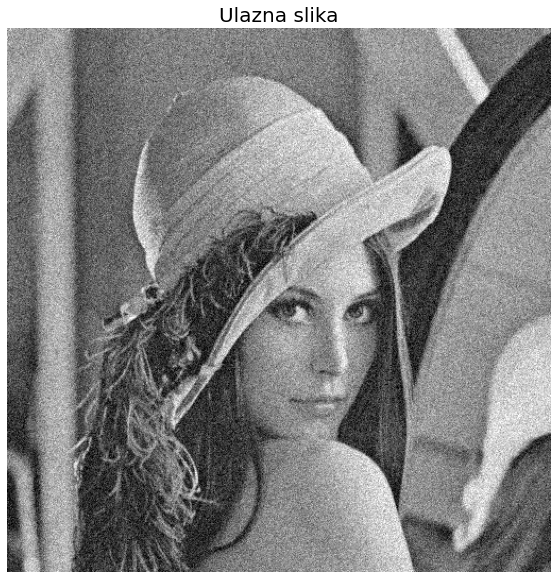

In [74]:
img = io.imread('sekvence/lena_noise.tif')

figsize = (10, 10)
fontsize = 20

plt.figure(figsize=figsize)
plt.imshow(img, cmap='gray')

plt.title('Ulazna slika', fontsize=fontsize)
plt.axis('off')
plt.show()

Dimenzije slike

In [75]:
N = img.shape[0]  # N   rows    y
M = img.shape[1]  # M   columns x

Proširivanje slike ponavljanjem ivičnih piksela. 

In [76]:
img_double = img / np.amax(img)

### Analiza varijansi lokalnih susedstava
Računanje varijansi za svako lokalno susedstvo.

Kako bismo izveli lokalno adaptivno usrednjavanje moramo proceniti varijansu šuma. Ovo činimo gledajući hisogram lokalnih varijansi slike. Ako se najveći broj piksela nalazi u uniformnim regionima slike onda će najveći broj susedstava imati baš varijansu šuma, dakle tražićemo maksimum histograma.

In [77]:
Rs = [2, 5, 10, 20]

In [78]:
img_vars = []

for r in Rs:
    img_var, _ = get_local_vars(img_double, r)
    img_vars.append(img_var)

100  %


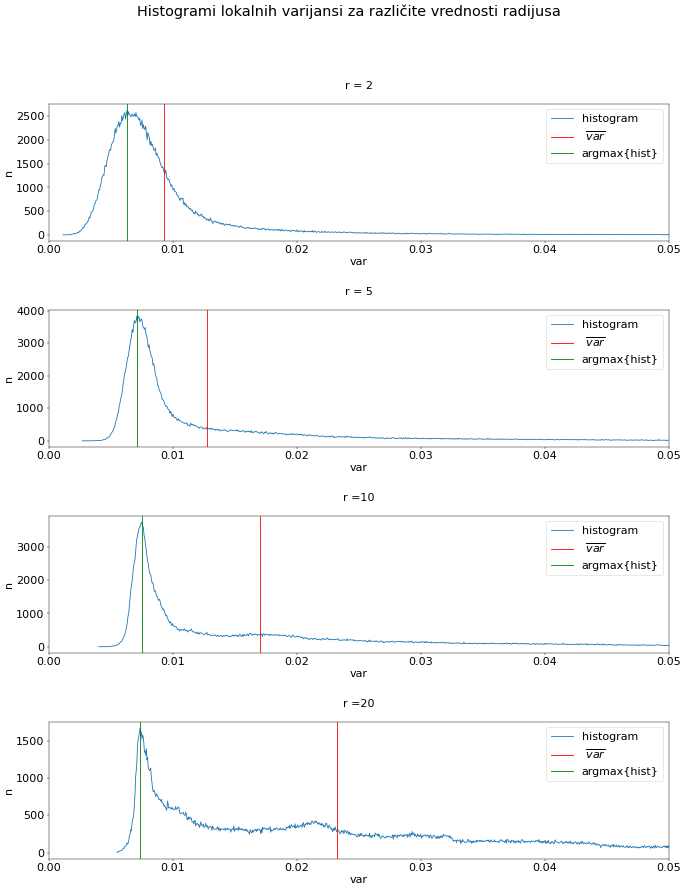

In [79]:
subplot_figsize = (20,25)

fig, ax = plt.subplots(len(Rs), 1, figsize=subplot_figsize, dpi=40);

fig.subplots_adjust(hspace=0.5)
suptitle_scale = 1.3

subplot_fontsize = 20

noise_var_argmax = []

for i, r in enumerate(Rs):
    hist_f, bin_edges = np.histogram(img_vars[i], bins=2000, range=(np.amin(img_vars[i]), np.amax(img_vars[i])))
    
    noise_var_argmax.append(bin_edges[np.argmax(hist_f)])
    
    ax[i].plot(bin_edges[0:-1], hist_f, label='histogram')
    ax[i].axvline(x=np.mean(img_vars[i]), color='r', label=" $\\overline{var}$")
    ax[i].axvline(x=bin_edges[np.argmax(hist_f)], color='green', label='argmax{hist}')
    
    ax[i].legend(fontsize=20)
    
    ax[i].tick_params(axis='both', which='major', labelsize=subplot_fontsize)
    
    ax[i].set_title('r =' + '%2.0d' % r + '\n', fontsize=subplot_fontsize)
    ax[i].set_xlabel('var', fontsize=subplot_fontsize)
    ax[i].set_ylabel('n', fontsize=subplot_fontsize)
    ax[i].set_xlim([0, 0.05])

fig.suptitle("Histogrami lokalnih varijansi za različite vrednosti radijusa", fontsize= suptitle_scale * fontsize)
plt.show()
    

Sa grafika vidimo da kako povećavamo radijus, glavni vrh histograma se sužava. Kao procenu varijanse šuma uzimamo varijansu na kojoj se javlja taj vrh.

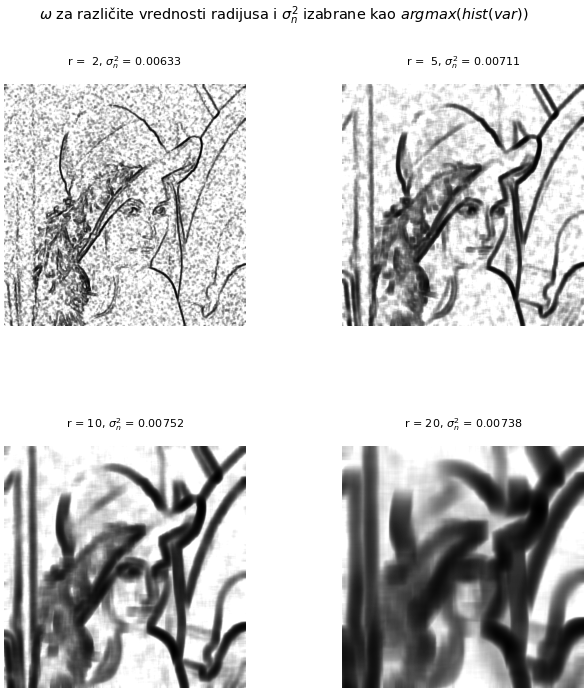

In [80]:
subplot_figsize = (20,20)

fig, ax = plt.subplots(2, 2, figsize=subplot_figsize, dpi=40);

fig.subplots_adjust(hspace=0.5)
suptitle_scale = 1.3

subplot_fontsize = 20

for i, r in enumerate(Rs):
    
    ax[i // 2, i % 2].imshow(get_omega(img_double, img_vars[i], noise_var_argmax[i]), cmap='gray')
    
    
    ax[i // 2, i % 2].set_title('r =' + '%3.0d' % r + ', $\sigma_n^2$ = ' + '%1.5f' % noise_var_argmax[i] + '\n', fontsize=subplot_fontsize)
    ax[i // 2, i % 2].axis('off')

fig.suptitle("$\omega$ za različite vrednosti radijusa i $\sigma_n^2$ izabrane kao $argmax(hist(var))$", fontsize= suptitle_scale * fontsize)
plt.show()
    

Ove vrednosti funkcije $w$ nisu ono što sam očekivao da ću dobiti. Za male vrednosti $r$ uniformni regioni neće biti očišćeni od šuma onoliko koliko bih voleo, a za veće vrednosti su oblasti ivica preširoke. Ne znam zašto je ovo slučaj ali zato predlažem drugi način.  
  
  
Ako zadržimo pretpostavku da se većina piksela slike nalazi u uniformnim regionima, što je ispunjeno za malo $r$, varijansu šuma možemo proceniti kao srednju vrednost svih varijansi lokalnih susedstava.

In [81]:
r = 3
img_var, img_mean = get_local_vars(img_double, r)

100  %


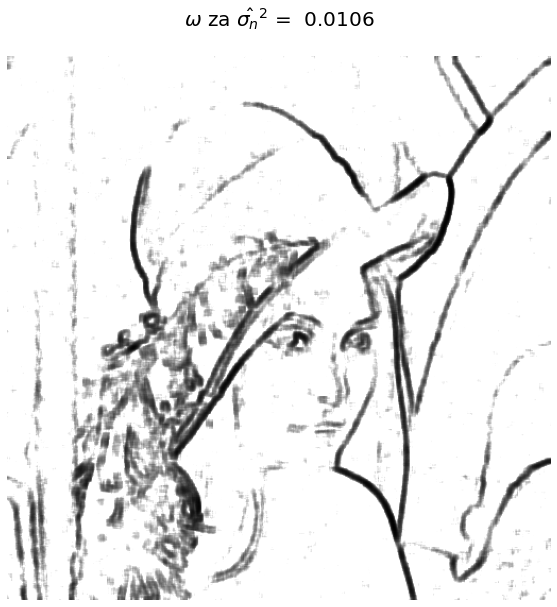

In [82]:
var_est_mean = np.mean(img_var)
omega = get_omega(img_double, img_var, var_est_mean)

plt.figure(figsize=figsize)
plt.imshow(omega, cmap='gray')

plt.title('$\omega$ za $\hat{\sigma_n}^2$ =  ' + "%.4f" % var_est_mean + '\n', fontsize=fontsize)
plt.axis('off')
plt.show()

### Filtriranje

Filtriranje zašumljene slike $g$ vrši se usrednjavanjem ali, pri tome davajući manju težinu oblastima koje obuhvataju ivice, a veću uniformnim regionima, posredstvom ranije određene funkcije $\omega$ date formulom (\ref{omega_w}). 

Filtriranu sliku, odnosno, procenu originalne slike $\hat{f}$ dobijamo sledećom formulom adaptivnog lokalnog usrednjavanja:


\begin{equation} \label{adaptivno_lokalno_usrednjavanje}
\hat{f}(x, y) = g(x, y) - \omega(x, y) \ (g(x,y) - \mu_{S_{xy}})
\end{equation}

gde je $\mu_{S_{xy}}$ srednja vrednost lokalnog susedstva $S_{xy}$.

In [83]:
var_est = var_est_mean
omega = get_omega(img_double, img_var, var_est)


img_filtered = img_double - omega * (img_double - img_mean)

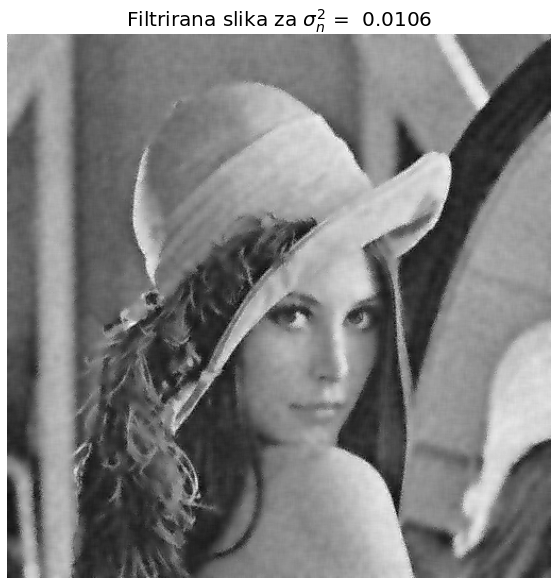

In [84]:
plt.figure(figsize=figsize)
plt.imshow(img_filtered, cmap='gray')

plt.title('Filtrirana slika za $\sigma_n^2$ =  ' + "%.4f" % var_est, fontsize=fontsize)
plt.axis('off')
plt.show()

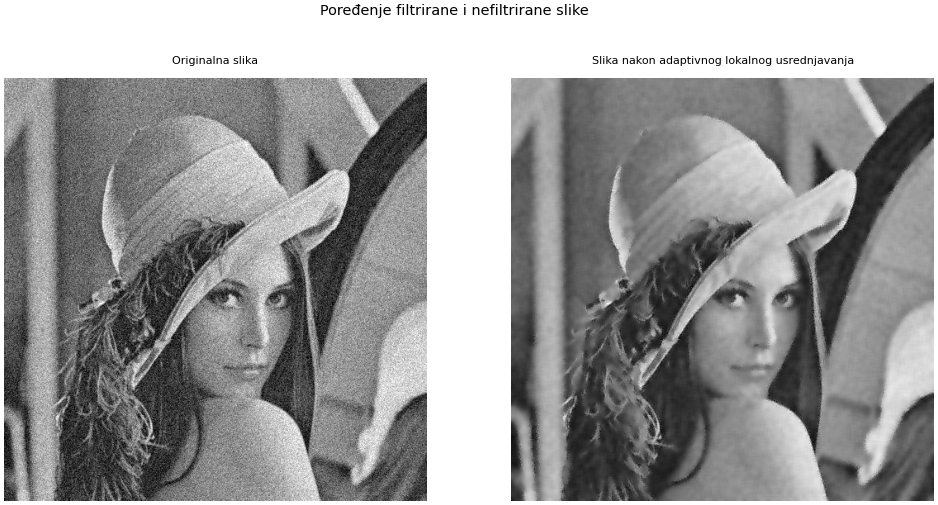

In [85]:
subplot_figsize = (30,15)

fig, ax = plt.subplots(1, 2, figsize=subplot_figsize, dpi=40);

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Originalna slika\n', fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(img_filtered, cmap='gray')
ax[1].set_title('Slika nakon adaptivnog lokalnog usrednjavanja\n', fontsize=fontsize)
ax[1].axis('off')



fig.suptitle("Poređenje filtrirane i nefiltrirane slike", fontsize= suptitle_scale * fontsize)

plt.show()

Filtrirana slika zaista deluje da ima manje šuma u uniformnim regionima, a da su ivice očuvane. Ako bolje pogledamo ivice možemo zaključiti, takođe, da one poseduju više šuma, što je posledica ovakvog selektivnog usrednjavanja.

Apdejtovanje numerisanja jednačina

In [86]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>